# Fit PDF with conditional variable

In this example, we show an unusual  fit where the total sample is not drawn form a single probability distribution, but each individual sample $x$ is drawn from a different distribution, whose parameters are determined by a conditional variable $y$.

In our example, we are drawing samples $x$ from varying Gaussian distributions. The location of each Gaussian is a function of the conditional variable $y$, but all share the same width parameter $\sigma$. We fit the shared parameter $\sigma$, but also the parameters $a$ and $b$ which determine how the location of each gaussian depends on $y$, assuming a line function $\mu = a + b y$.

This tutorial reproduces a [corresponding one from RooFit](https://root.cern.ch/doc/master/rf303__conditional_8C.html).

In [21]:
from iminuit.cost import UnbinnedNLL
from iminuit import Minuit
import numpy as np
import boost_histogram as bh
import matplotlib.pyplot as plt
from numba_stats import norm, expon

In [100]:
rng = np.random.default_rng(1)

# conditional variable: each sample is paired with a random y parameter
y = rng.normal(0, 10, size=10000)
y = y[np.abs(y) < 10]  # truncate at 10

# location of each gaussian is a function of y
def mu(y, a, b):
    return a + b * y

# draw samples from Gaussians whose locations depend on y
a = 0
b = 0.5
sigma = 1.0
x = rng.normal(mu(y, a, b), sigma)

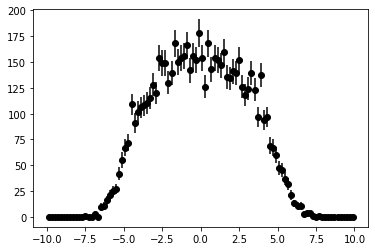

In [101]:
ax = bh.axis.Regular(100, -10, 10)
h = bh.Histogram(ax)
h.fill(x)
plt.errorbar(ax.centers, h.values(), h.variances() ** 0.5, fmt="ok");

In [102]:
def model(xy, a, b, sigma):
    x, y = xy
    mu = a + b * y
    return norm.pdf(x, mu, sigma)

nll = UnbinnedNLL((x, y), model)

m = Minuit(nll, 0.0, 0.0, 2.0)
m.limits["sigma"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.93e+04                   │              Nfcn = 130              │
│ EDM = 2.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │  -0.010   │   0.012   │            │            │         │         │       │
│ 1 │ b     │  0.4993   │  0.0022   │            │            │         │         │       │
│ 2 │ sigma │   0.986   │   0.008   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        a        b    sigma │
├───────┼────────────────────────────┤
│     a │ 0.000142 1.31e-08 5.73e-08 │
│     b │ 1.31e-08 4.76e-06 1.02e-08 │
│ sigma │ 5.73e-08 1.02e-08 7.08e-05 │
└───────┴────────────────────────────┘

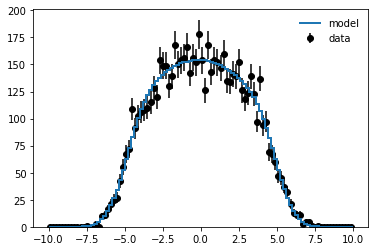

In [107]:
# construct model representation for comparison with data histogram
a, b, sigma = m.values

# get expected content per bin from cdf, sum over the individual cdfs
v = np.diff(np.sum(norm.cdf(ax.edges[:,np.newaxis],
                            mu(y, a, b), sigma), axis=1))

plt.stairs(v, ax.edges, label="model", zorder=5, lw=2)
plt.errorbar(ax.centers, h.values(), h.variances() ** 0.5,
             fmt="ok", label="data")
plt.legend(frameon=False);